In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import arviz
import pathlib
from matplotlib import animation

In [22]:
sns.set_context("talk")
%config InlineBackend.figure_format = 'retina'
##plt.style.use('arviz-darkgrid')
sns.set_style("darkgrid")

In [23]:
ds = xr.open_dataset("benchmarks.nc")

Text(0.5, 1.0, 'ecdf plot of nutpie speedups')

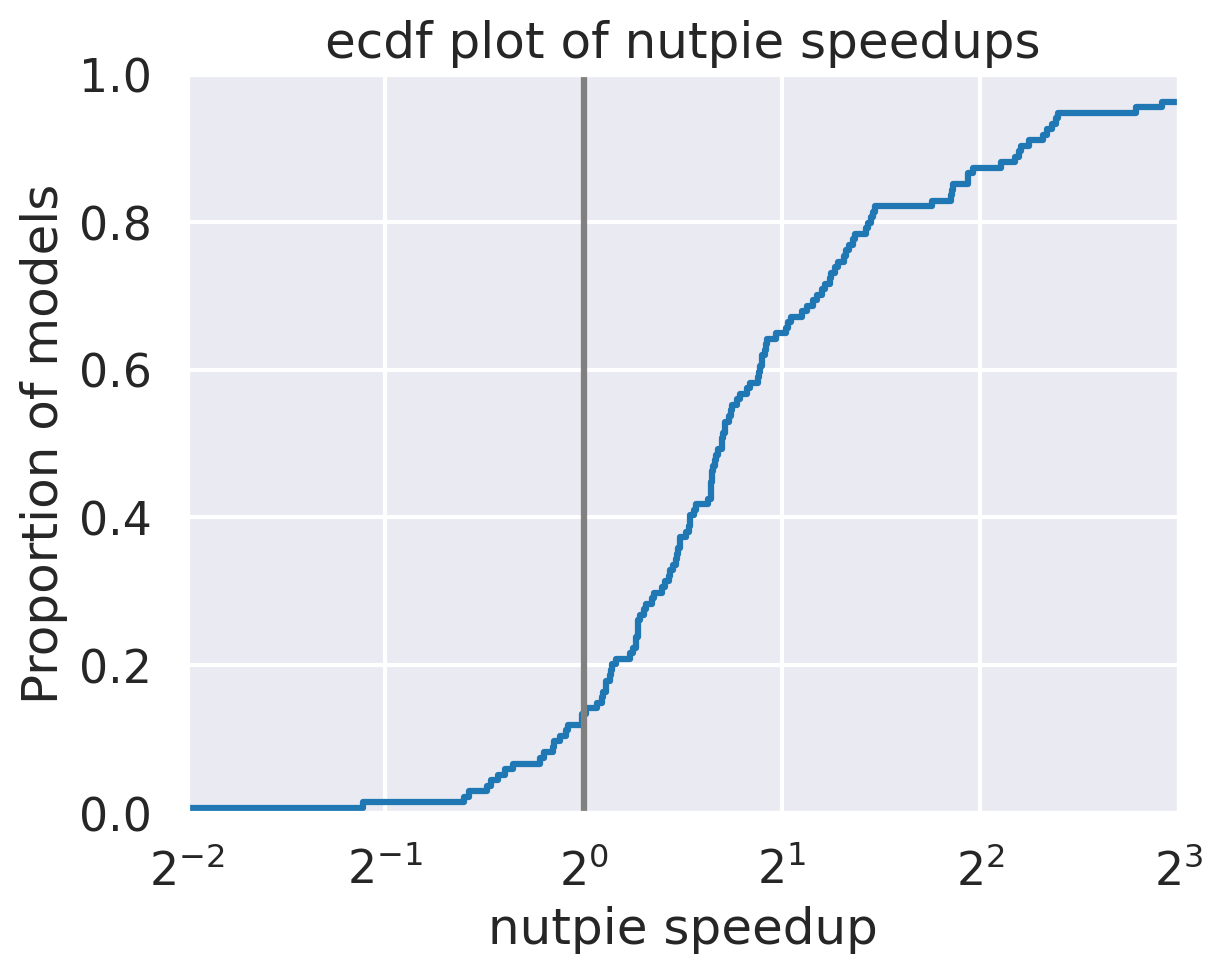

In [27]:
#bad = (ds.min_effective_draws < 500) | (ds.divergences > 0)
#ds = ds.sel(model_name=~bad.all(["sampler_name", "machine"]))
ds_ = ds.sel(model_name=ds.wall_time.min(["machine", "sampler_name"]) > 0)
ds["speedup"] = ds_.seconds_per_ess.sel(sampler_name="cmdstanpy") / ds.seconds_per_ess

sns.ecdfplot(ds.speedup.sel(sampler_name="nutpie-stan-1000", machine="r7a").values)
plt.xscale("log", base=2)
plt.axvline(1, color="gray")
plt.xlim(2**(-2), 2**3)
plt.xlabel("nutpie speedup")
plt.ylabel("Proportion of models")
plt.title("ecdf plot of nutpie speedups")

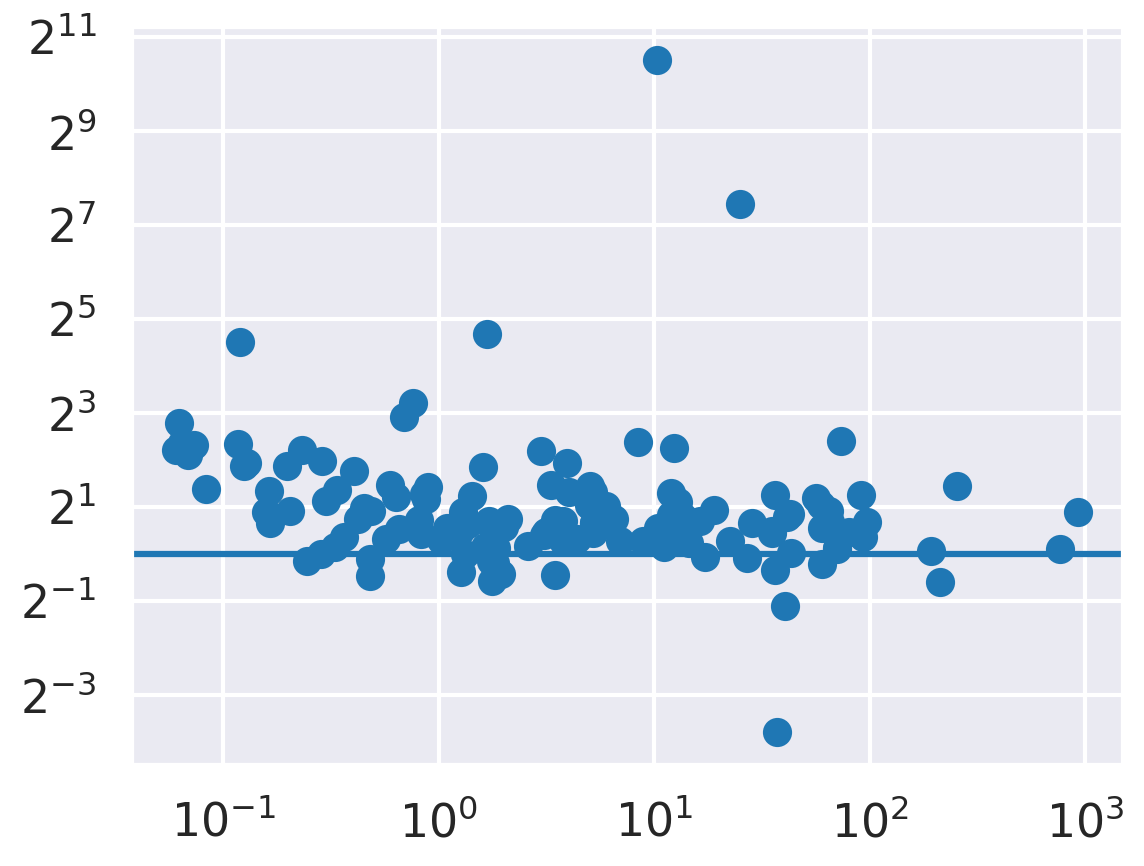

In [35]:
plt.scatter((ds.wall_time.sel(sampler_name="cmdstanpy", machine="r7a")), ds.speedup.sel(sampler_name="nutpie-stan-1000", machine="r7a"))
plt.yscale("log", base=2)
plt.xscale("log", base=10)
#plt.axhline(0)
plt.axhline(1)
#plt.ylim(0.1, 6)

(10, 129587.72909837571)

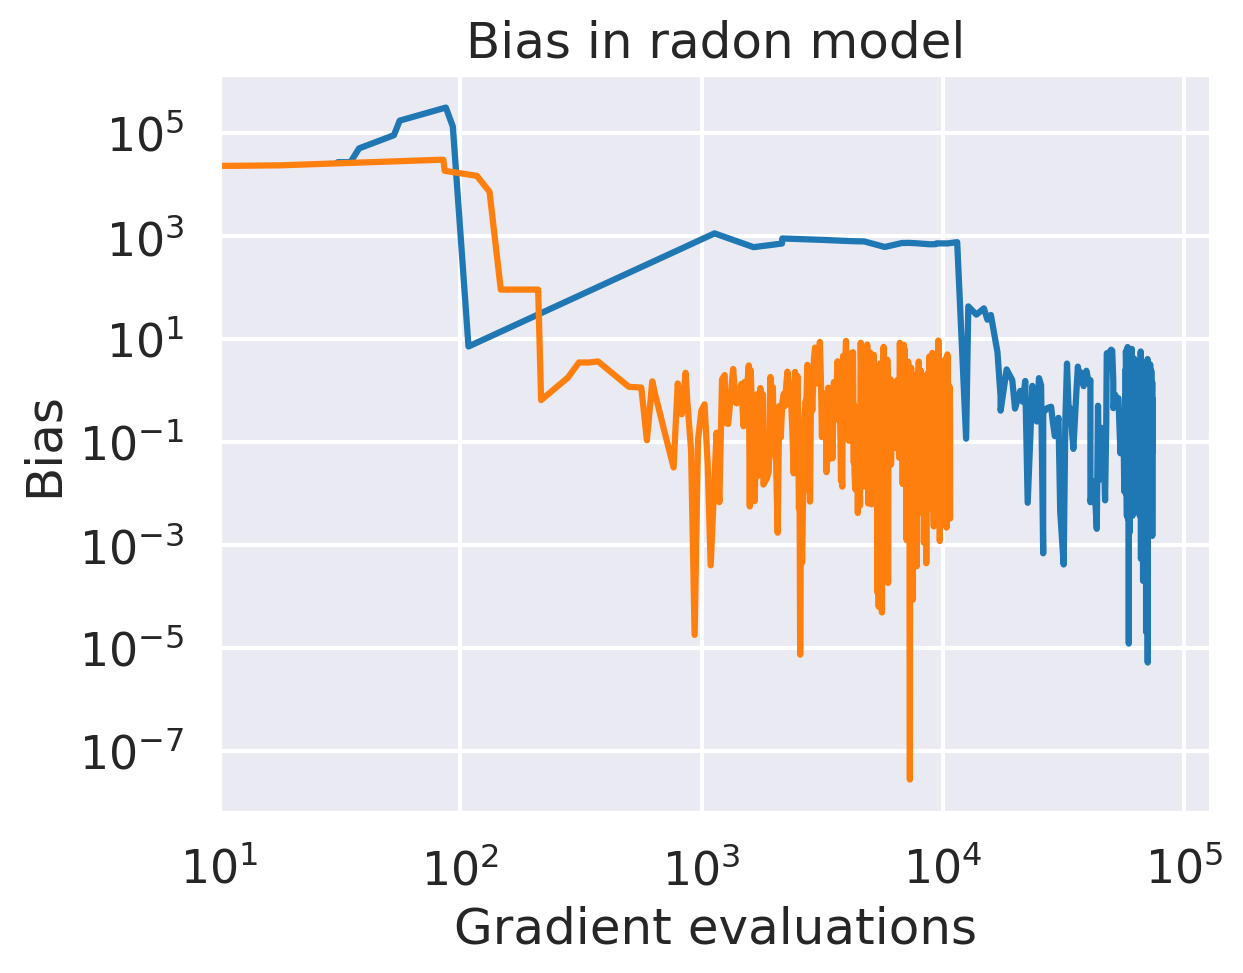

In [38]:
base = pathlib.Path("/mnt/harddrives/data/pymc-labs/samplerlab/traces-stan-R7a-xlarge/traces-stan/2024-07-31T134259/")

base = base / "radon_all-radon_variable_intercept_slope_noncentered"

stan = arviz.from_zarr(str(base / "cmdstanpy-cpu" / "trace.zarr")).load()
nutpie = arviz.from_zarr(str(base / "nutpie-stan-1000-cpu" / "trace.zarr")).load()

bias_stan = (stan.posterior.mean(["draw", "chain"]) - stan.warmup_posterior) / stan.posterior.std(["draw", "chain"])
bias_nutpie = (nutpie.posterior.mean(["draw", "chain"]) - nutpie.warmup_posterior) / nutpie.posterior.std(["draw", "chain"])

subs = dict(draw=slice(None, 500), chain=0)

plt.plot(stan.warmup_sample_stats.n_steps.cumsum().isel(**subs), bias_stan.sigma_y.isel(**subs) ** 2, color="C0");
plt.plot(nutpie.warmup_sample_stats.n_steps.cumsum().isel(**subs), bias_nutpie.sigma_y.isel(**subs) ** 2, color="C1");
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Gradient evaluations")
plt.ylabel("Bias")
plt.title("Bias in radon model")
plt.xlim(10, None)

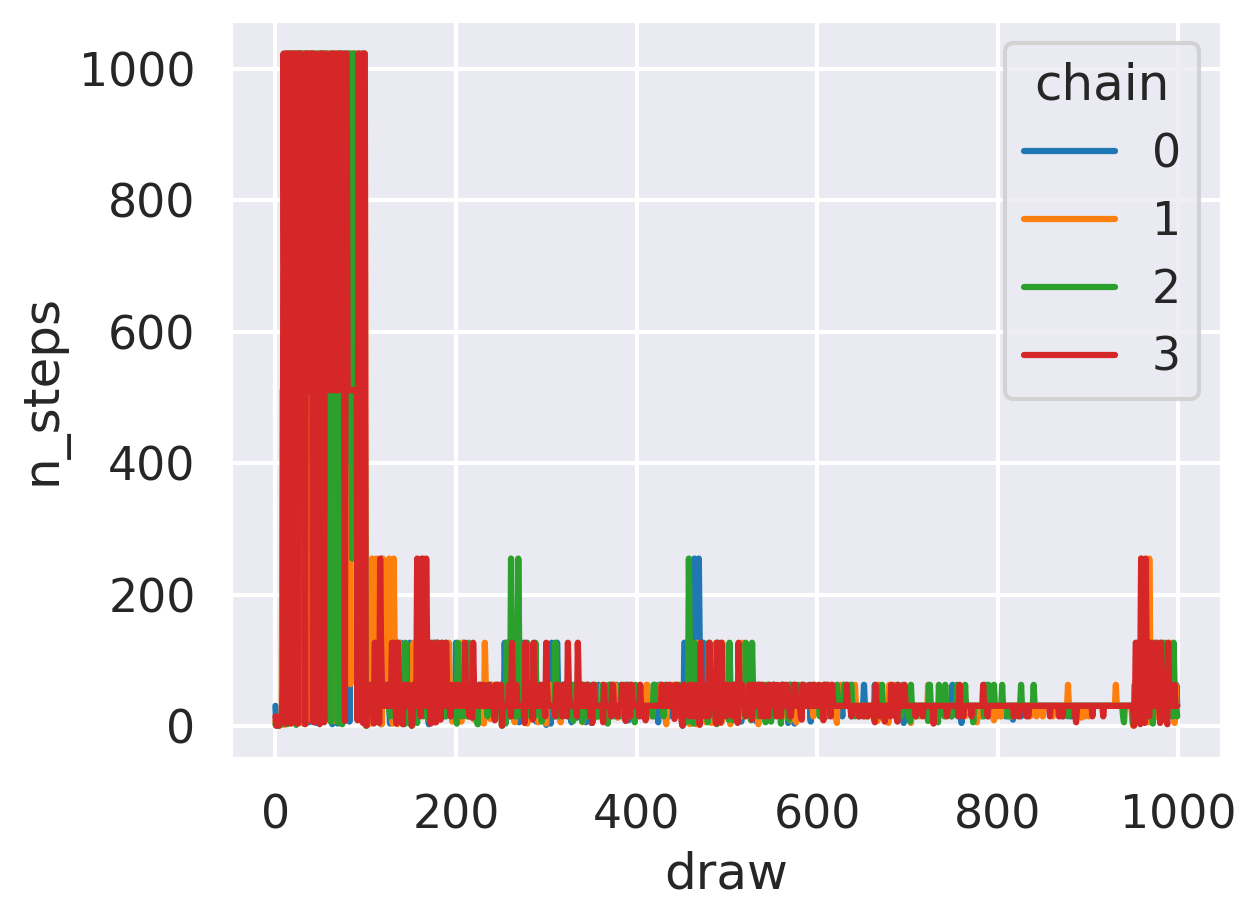

In [39]:
stan.warmup_sample_stats.n_steps.plot.line(x="draw")

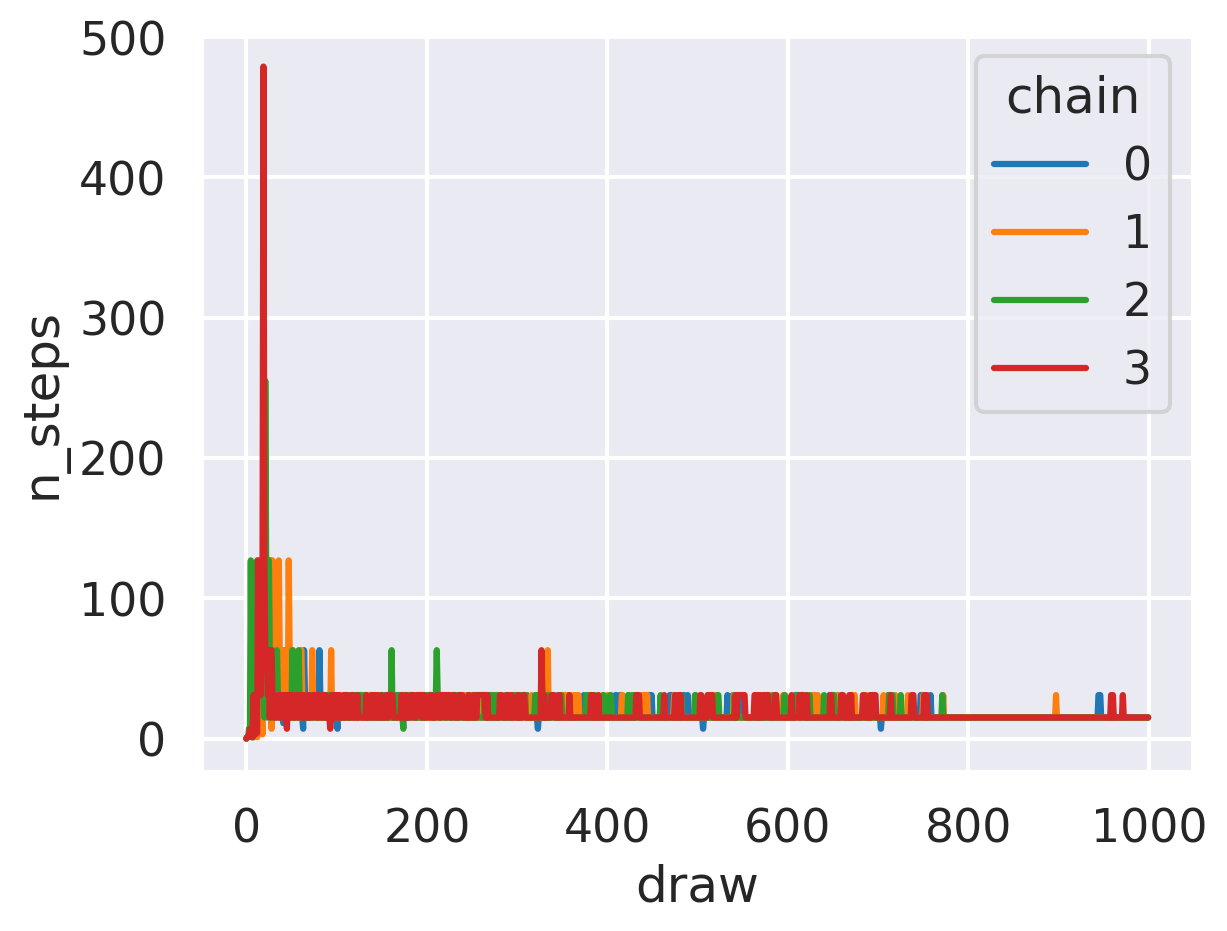

In [40]:
nutpie.warmup_sample_stats.n_steps.plot.line(x="draw")

In [41]:
cov = np.array([[1., 0.96], [0.96, 1.]])
cov[:, 0] /= 6
cov[0, :] /= 6

prec = np.linalg.inv(cov)

draws = np.random.multivariate_normal(mean=np.zeros(len(cov)), cov=cov, size=500)
grads = -(prec @ draws.T).T

draws = draws[:, :2]
grads = grads[:, :2]

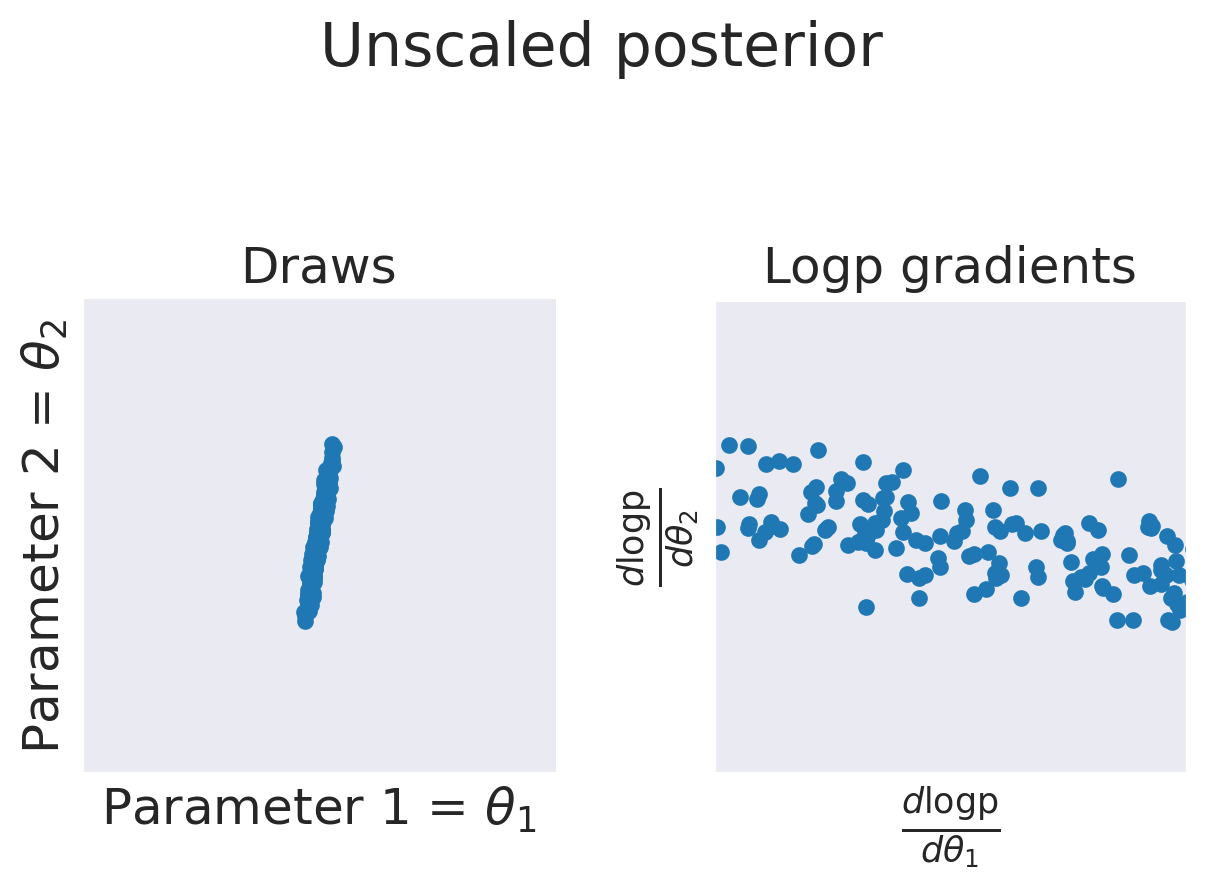

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, aspect="equal")

sns.despine(fig=fig)

lim = 8

ax.scatter(*draws.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Draws")
ax.set_xlabel(r"Parameter 1 = $\theta_1$")
ax.set_ylabel(r"Parameter 2 = $\theta_2$")

#sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
#ax.plot(*np.array([(-2, -3), (2, -3)]).T, color="black", marker="|")
#ax.annotate("1", xy=(0., -3), xytext=(-0.5, -5),)

ax = fig.add_subplot(1, 2, 2, aspect="equal")
ax.scatter(*grads.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel(r"$\frac{d\text{logp}}{d\theta_1}$")
ax.set_ylabel(r"$\frac{d\text{logp}}{d\theta_2}$")

#sns.despine(top=True, right=True, left=True, bottom=True, fig=fig)
ax.set_xticks([])
ax.set_yticks([])

ax.set_title("Logp gradients")
fig.suptitle("Unscaled posterior")
fig.tight_layout()


In [43]:
scale_stan = np.sqrt(np.diag(cov))[:2]
draws_stan = draws / scale_stan
grads_stan = grads * scale_stan

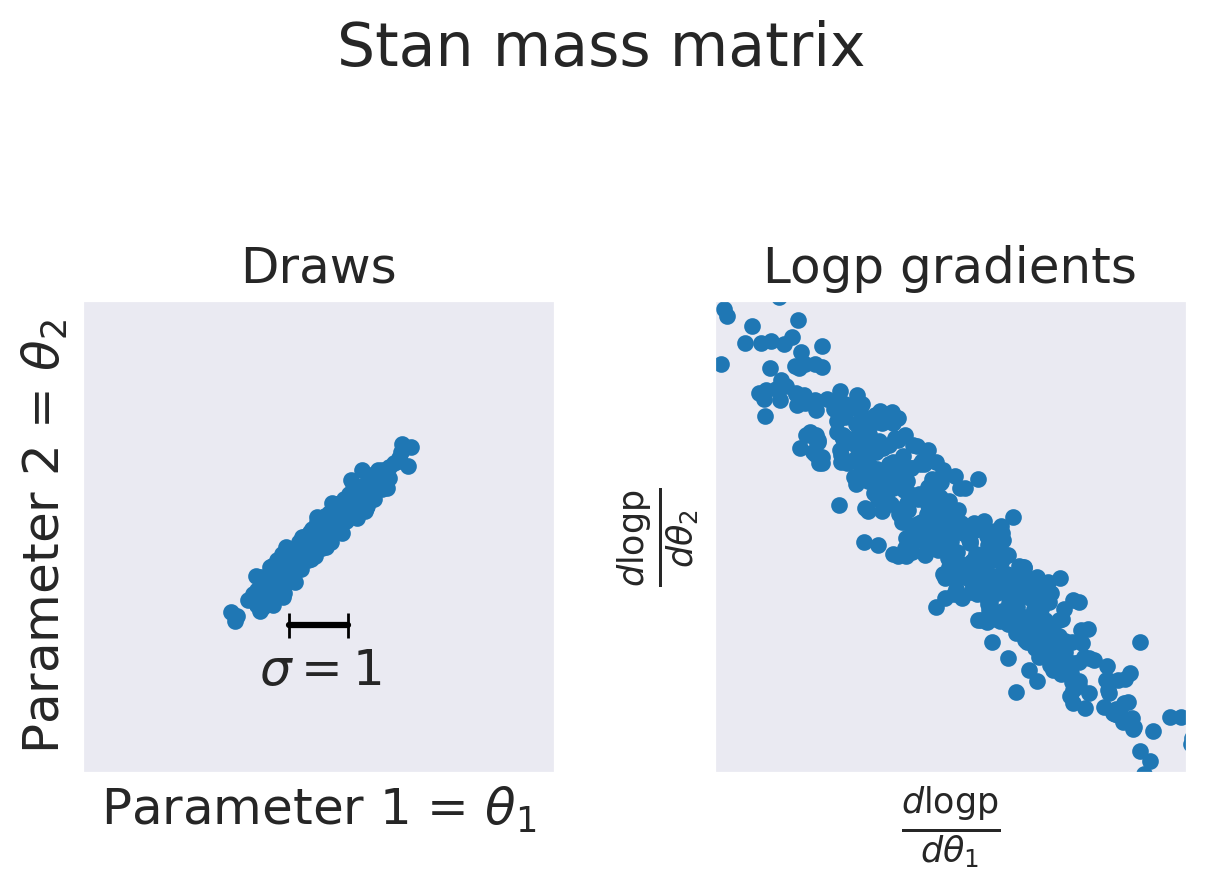

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, aspect="equal")

lim = 8

ax.scatter(*draws_stan.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Draws")
ax.set_xlabel(r"Parameter 1 = $\theta_1$")
ax.set_ylabel(r"Parameter 2 = $\theta_2$")


ax.plot(*np.array([(-1, -3), (1, -3)]).T, color="black", marker="|")
ax.annotate(r"$\sigma = 1$", xy=(0., -3), xytext=(-2, -5),)

ax = fig.add_subplot(1, 2, 2, aspect="equal")
ax.scatter(*grads_stan.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$\frac{d\text{logp}}{d\theta_1}$")
ax.set_ylabel(r"$\frac{d\text{logp}}{d\theta_2}$")

#ax.plot(line_x, line_y, marker='|', color='red', markersize=20, linewidth=2, label='Length = 1')

ax.set_title("Logp gradients")
fig.suptitle("Stan mass matrix")
fig.tight_layout()


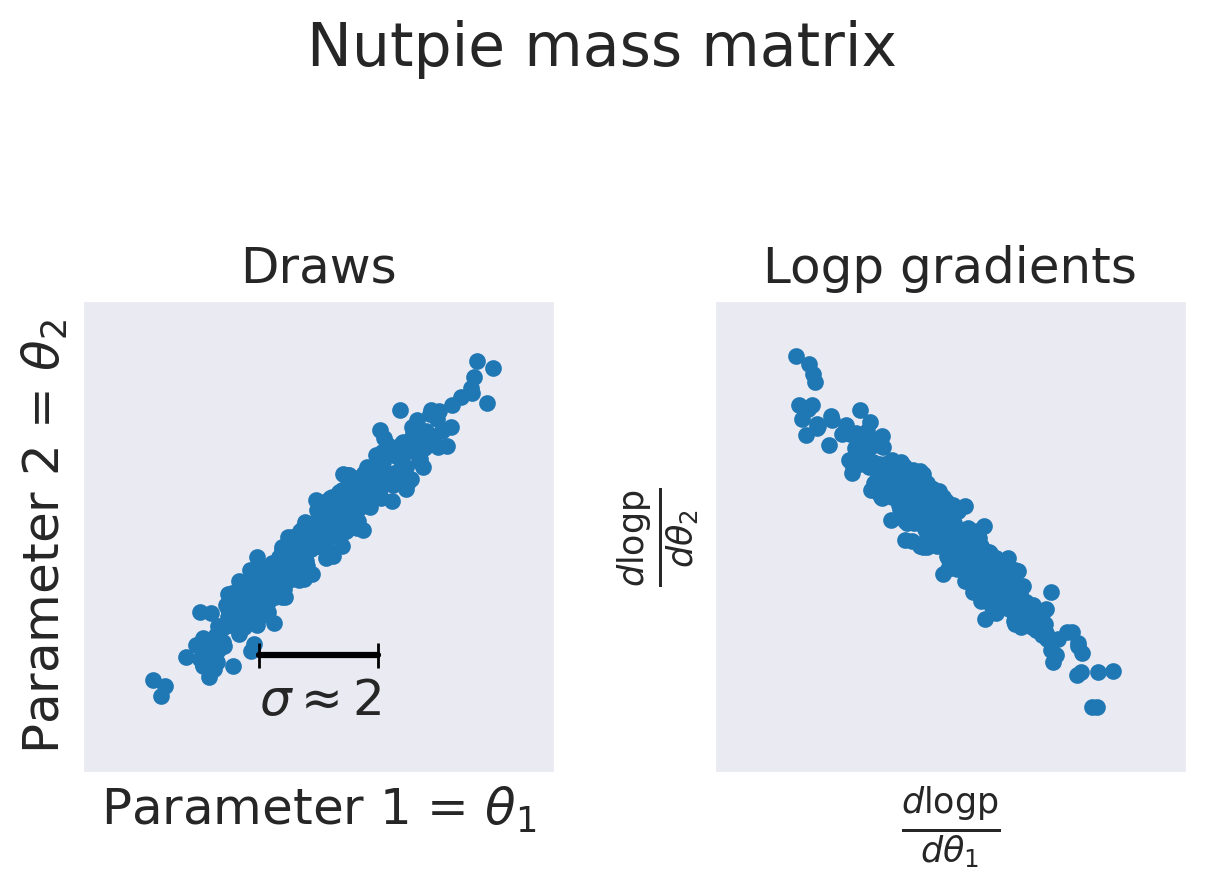

In [45]:
scale_grads = np.sqrt(np.sqrt(np.diag(cov)) / np.sqrt(np.diag(prec)))[:2]
draws_grads = draws / scale_grads
grads_grads = grads * scale_grads

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, aspect="equal")

lim = 8

ax.scatter(*draws_grads.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"Parameter 1 = $\theta_1$")
ax.set_ylabel(r"Parameter 2 = $\theta_2$")

ax.plot(*np.array([(-2, -4), (2, -4)]).T, color="black", marker="|")
ax.annotate(r"$\sigma \approx 2$", xy=(0., -4), xytext=(-2, -6),)

ax.set_title("Draws")

ax = fig.add_subplot(1, 2, 2, aspect="equal")
ax.scatter(*grads_grads.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$\frac{d\text{logp}}{d\theta_1}$")
ax.set_ylabel(r"$\frac{d\text{logp}}{d\theta_2}$")

ax.set_title("Logp gradients")
fig.suptitle("Nutpie mass matrix")
fig.tight_layout()


In [46]:
print((np.log(np.linalg.eigvalsh(np.cov(draws_stan.T))) ** 2).sum())
print((np.log(np.linalg.eigvalsh(np.cov(draws_grads.T))) ** 2).sum())

11.140190826831574
8.285861867911965


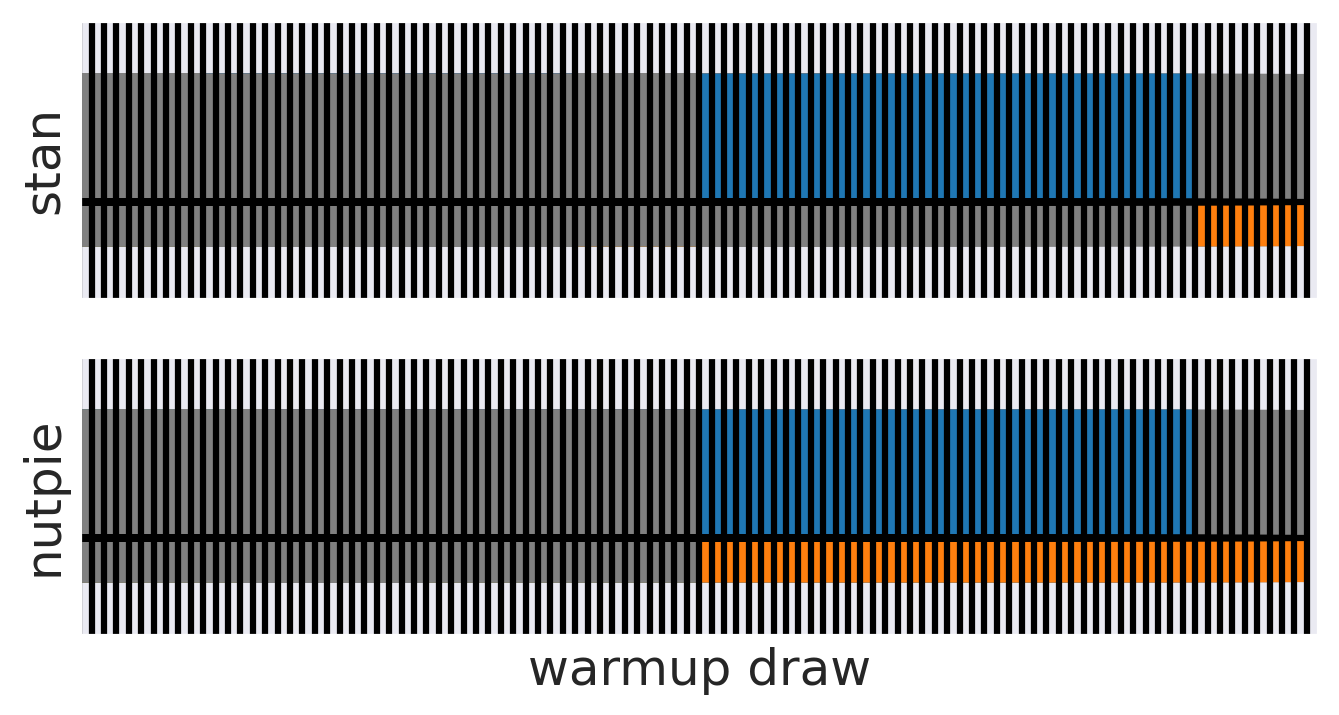

In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))


frames = []

# figsize keyword talks some obscure units which need a conversion from standard units
#fig = plt.figure(figsize=np.array([210,297]) / 25.4)

#ax1.set_position([0, 0.5, 1, 0.5])
ax1.set_xticks([])
ax1.set_yticks([])

#ax2.set_position([0, 0, 1, 0.5])
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_ylabel("stan")
ax2.set_ylabel("nutpie")

ax1.set_xlim(0, 100)
ax1.set_ylim(0, 1)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 1)

ax2.set_xlabel("warmup draw")

def rect(x, y, *, color="C0"):
    return plt.Rectangle((x, 0.35), y - x, 0.45, facecolor=color, edgecolor=color)

def rect_step(x, y, *, color="C1"):
    return plt.Rectangle((x, 0.2), y - x, 0.15, facecolor=color, edgecolor=color)

frames = []
for i in range(100):
    frame = []

    frame.append(ax2.add_artist(rect(0, i, color="gray")))
    frame.append(ax1.add_artist(rect(0, i, color="gray")))

    frame.append(ax2.add_artist(rect_step(0, i, color="gray")))
    frame.append(ax1.add_artist(rect_step(0, i, color="gray")))

    frame.append(ax1.axvline(i, color="black"))
    frame.append(ax1.hlines(0.35, 0, i, color="black"))

    if i < 10:
        frame.append(ax1.add_artist(rect_step(0, i)))
    elif i < 40:
        frame.append(ax1.add_artist(rect_step(0, 10)))
    elif i < 50:
        frame.append(ax1.add_artist(rect(10, 40)))
        frame.append(ax1.add_artist(rect_step(40, i)))
    elif i < 90:
        frame.append(ax1.add_artist(rect(10, 40)))
        frame.append(ax1.add_artist(rect_step(40, 50)))
    else:
        frame.append(ax1.add_artist(rect(50, 90)))
        frame.append(ax1.add_artist(rect_step(90, i)))

    frame.append(ax2.axvline(i, color="black"))
    frame.append(ax2.hlines(0.35, 0, i, color="black"))

    if i < 10:
        frame.append(ax2.add_artist(rect(0, i)))
    elif i < 15:
        frame.append(ax2.add_artist(rect(5, i)))
    elif i < 20:
        frame.append(ax2.add_artist(rect(10, i)))
    elif i < 50:
        frame.append(ax2.add_artist(rect(15, i)))
    elif i < 80:
        frame.append(ax2.add_artist(rect(30, i)))
    elif i < 90:
        frame.append(ax2.add_artist(rect(50, i)))
    else:
        frame.append(ax2.add_artist(rect(50, 90)))

    if i < 20:
        frame.append(ax2.add_artist(rect_step(0, i)))
    else:
        frame.append(ax2.add_artist(rect_step(50, i)))

    frames.append(frame)

In [ ]:
ani = animation.ArtistAnimation(fig=fig, artists=frames, interval=400)
ani.save(
    filename="plots/early_adapt2.gif",
    writer="pillow",
    savefig_kwargs=dict(transparent=True, facecolor=(1, 1, 1, 0), edgecolor=(1, 1, 1, 0)),
    dpi=400,
)